In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("lm.mplstyle")

import os
import numpy as np
import samplebase as sb
import pandas as pd
import case_config

In [2]:
DATA_ROOT = "/home/mho/Dropbox/phd/readdy_learn/reaction_learn_data"

In [3]:
def load(file):
    with open(os.path.join(DATA_ROOT, file), 'rb') as f:
        X = np.load(f)
        rates = X['rates']
        l1_dev = X['l1_dev']
        alpha_val = X['alpha_val']
        gillespie_realizations = X['gillespie_realisations']
        desired_rates = X['desired_rates']
        assert np.allclose(desired_rates, case_config.DESIRED_RATES)
    return rates, l1_dev, alpha_val, gillespie_realizations, desired_rates

In [4]:
rates_normal, l1_normal, alpha_normal, gillespie_realizations_normal, _ = load('case3_validation_alphas_and_solutions_averagefolds_normaltraj_20folds.npz')

In [5]:
# rates_zipped, l1_zipped, alpha_zipped, gillespie_realizations_zipped, _ = load('case3_validation_alphas_and_solutions_averagefolds_zippedtraj_20folds.npz')

In [6]:
# assert all(gillespie_realizations_normal == gillespie_realizations_zipped)
gillespie_realizations = gillespie_realizations_normal

In [7]:
def plot_failure_rates():
    failure_rates = []
    failure_rates_std = []
    for gillespie_realization in range(len(gillespie_realizations)):
        estimated_rates = rates_normal[gillespie_realization]
        r = [case_config.failure_rate(x) for x in estimated_rates]
        failure_rates.append(np.mean(r))
        failure_rates_std.append(np.std(r))
        
    failure_rates = np.array(failure_rates)
    failure_rates_std = np.array(failure_rates_std)
    plt.plot(gillespie_realizations, failure_rates)
    plt.fill_between(gillespie_realizations, y1=failure_rates-failure_rates_std, y2=failure_rates+failure_rates_std, alpha=0.3)
    plt.xscale('log')
    plt.xlabel('Number of measurements')
    plt.ylabel('Failure rate')

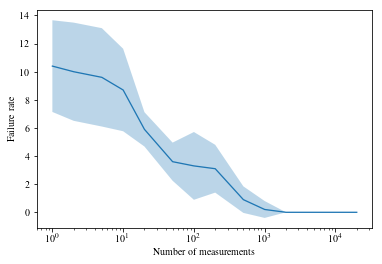

In [8]:
plot_failure_rates()

In [9]:
def plot_l1_difference(l1_err, out_fname):
    mean = np.mean(l1_err, axis=1)
    err = np.std(l1_err, axis=1) #/ np.sqrt(10.) # 10 iids
    plt.plot(gillespie_realizations, mean)
    plt.fill_between(gillespie_realizations, y1=np.clip(mean-err, 0., 1e16), y2=mean+err, alpha=0.3)
    # plt.hlines(.38, xmin=0, xmax=gillespie_realizations[-1], linestyles='dashed')
    plt.xscale("log")
    plt.xlabel("Number of measurements")
    plt.ylabel(r"$|\xi_\mathrm{cv}-\hat{\xi}|_1$")
    # plt.title("Deviation of estimated rates from desired rates")
    ymin, ymax = plt.ylim()
    #plt.ylim(-1,ymax)
    plt.savefig(out_fname, bbox_inches="tight", transparent=True)

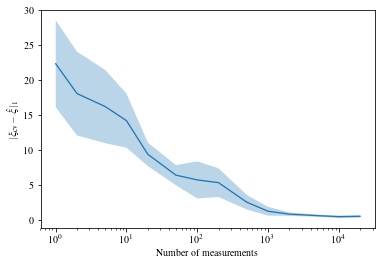

In [10]:
plot_l1_difference(l1_normal, 'case3_convergence_averagefolds.pdf')

In [11]:
# plot_l1_difference(l1_zipped, 'case3_convergence_averagefolds_zipped.pdf')

In [19]:
reg = np.mean(rates_normal[-1], axis=0)

In [20]:
traj = case_config.get_traj_from_file(os.path.join(DATA_ROOT, "gillespie_trajs_init_1.h5"), 20000, 0)

Text(0,0.5,'Concentration in a.u.')

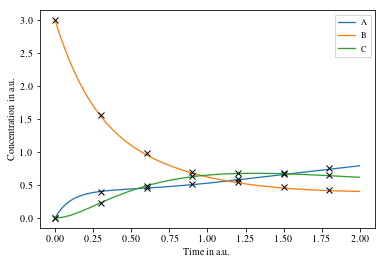

In [21]:
estimated_rates = reg[:]
estimated_rates[np.where(estimated_rates < case_config.CASE1_CUTOFF)] = 0
xs, ys = case_config.integrate(case_config.INITIAL_CONDITIONS[0], estimated_rates)

#species = np.array([1, 2, 4, 5, 7, 8])
species = np.array([2, 5, 8])
t = np.arange(len(traj[0]))*case_config.TIMESTEP
for ix, s in enumerate(species):
    name = case_config.SPECIES_TEX[s]
    plt.plot(t, traj[0][:,s], label=r"${}$".format(name), color='C{}'.format(ix))
    plt.plot(xs[::100], ys[:, s][::100], 'kx')
plt.legend()
plt.xlabel('Time in a.u.')
plt.ylabel('Concentration in a.u.')

In [23]:
traj = case_config.get_traj_from_file(os.path.join(DATA_ROOT, "gillespie_trajs_init_3.h5"), 20000, 0)

Text(0,0.5,'Concentration in a.u.')

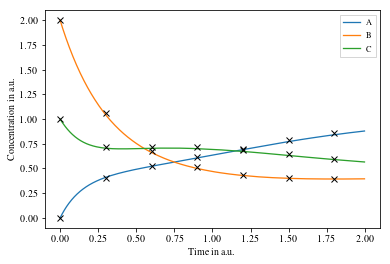

In [24]:
estimated_rates = reg[:]
estimated_rates[np.where(estimated_rates < case_config.CASE1_CUTOFF)] = 0
xs, ys = case_config.integrate(case_config.INITIAL_CONDITIONS[1], estimated_rates)

#species = np.array([1, 2, 4, 5, 7, 8])
species = np.array([2, 5, 8])
t = np.arange(len(traj[0]))*case_config.TIMESTEP
for ix, s in enumerate(species):
    name = case_config.SPECIES_TEX[s]
    plt.plot(t, traj[0][:,s], label=r"${}$".format(name), color='C{}'.format(ix))
    plt.plot(xs[::100], ys[:, s][::100], 'kx')
plt.legend()
plt.xlabel('Time in a.u.')
plt.ylabel('Concentration in a.u.')